In [6]:
OPENAI_API_KEY = "ENTER_YOUR_API_KEY"

#### Question Answering

- We have gone over how to retrieve documents that are relevant for a given question.
- The next step is to take those documents, take the original questions, pass them both to a language model, and ask it to answer the question.
- We aree going to go over that in this lesson, and the few different ways that we can accomplish that task.

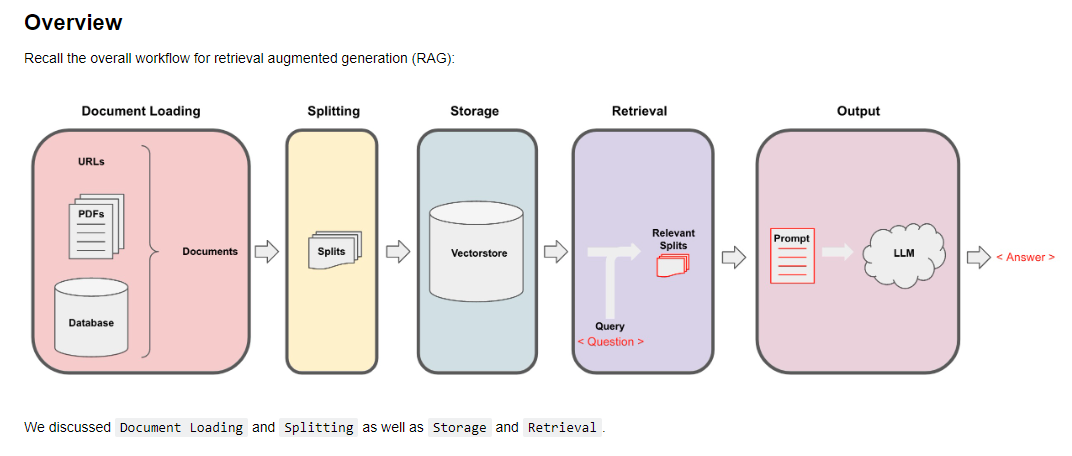

- Multiple relevant documents have been retrieved from the vector store
- Potentially compress the relevant splits to fit into the LLM context
- Send the information along with our question to an LLM to select and format an answer

#### General flow:

- The general flow for this goes, the question comes in, we look up the relevant documents, we then pass those splits along with a system prompt and the human question to the language model and get the answer.

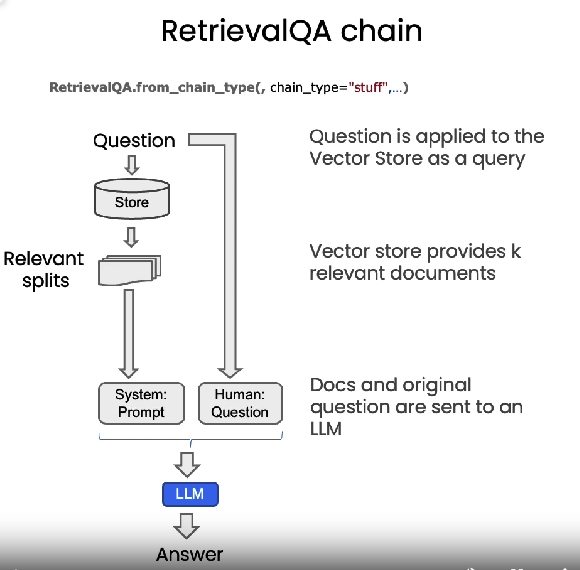

- By default, we just pass all the chunks into the same context window, into the same call of the language model. However, there are a few different methods we can use that have pros and cons to that.
- Most of the pros come from the fact that sometimes there can be a lot of documents and we just simply can't pass them all into the same context window.


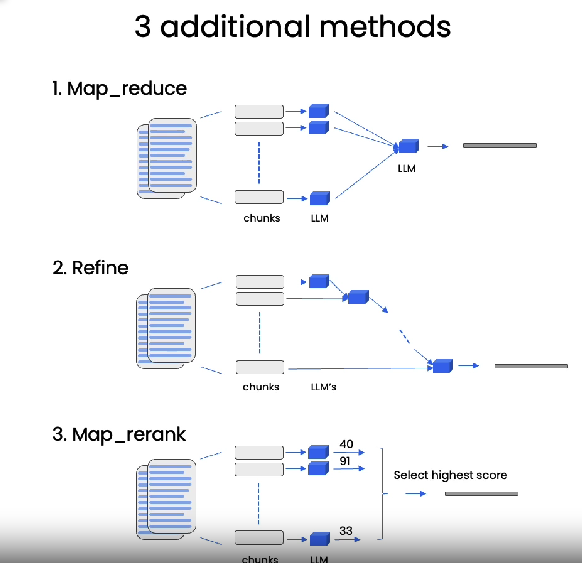

In [2]:
import os
import openai
import sys
# sys.path.append('../..')

# from dotenv import load_dotenv, find_dotenv
# _ = load_dotenv(find_dotenv()) # read local .env file

# openai.api_key  = os.environ['OPENAI_API_KEY']

- The code below was added to assign the openai LLM version filmed until it is deprecated, currently in Sept 2023. 
- LLM responses can often vary, but the responses may be significantly different when using a different model version.

In [3]:
import datetime
current_date = datetime.datetime.now().date()
if current_date < datetime.date(2023, 9, 2):
    llm_name = "gpt-3.5-turbo-0301"
else:
    llm_name = "gpt-3.5-turbo"
print(llm_name)

gpt-3.5-turbo-0301


In [7]:
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
# persist_directory = 'docs/chroma/'
# embedding = OpenAIEmbeddings()
# vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [9]:
vectordb = FAISS.load_local("docs/faiss_index", embedding_model)

In [10]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

3

In [12]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name=llm_name, temperature=0, openai_api_key=OPENAI_API_KEY)

#### RetrievalQA chain

In [13]:
from langchain.chains import RetrievalQA

In [14]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [15]:
result = qa_chain({"query": question})

In [16]:
result["result"]

'The major topic for this class is machine learning. Additionally, the class may cover statistics and algebra as refreshers in the discussion sections. Later in the quarter, the discussion sections will also cover extensions for the material taught in the main lectures.'

#### Prompt

In [17]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [18]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [19]:
question = "Is probability a class topic?"

In [20]:
result = qa_chain({"query": question})

In [21]:
result["result"]

'Yes, probability is assumed to be a prerequisite for this class. The instructor assumes familiarity with basic probability and statistics, and will go over some of the prerequisites in the discussion sections as a refresher course. Thanks for asking!'

In [22]:
result["source_documents"][0]

Document(page_content="of this class will not be very program ming intensive, although we will do some \nprogramming, mostly in either MATLAB or Octa ve. I'll say a bit more about that later.  \nI also assume familiarity with basic proba bility and statistics. So most undergraduate \nstatistics class, like Stat 116 taught here at Stanford, will be more than enough. I'm gonna \nassume all of you know what ra ndom variables are, that all of you know what expectation \nis, what a variance or a random variable is. And in case of some of you, it's been a while \nsince you've seen some of this material. At some of the discussion sections, we'll actually \ngo over some of the prerequisites, sort of as  a refresher course under prerequisite class. \nI'll say a bit more about that later as well.  \nLastly, I also assume familiarity with basi c linear algebra. And again, most undergraduate \nlinear algebra courses are more than enough. So if you've taken courses like Math 51, \n103, Math 113 or 

- So far, we have been using the stuff technique, the technique that we use by default, which basically just stuffa all the documents into the final prompt.
- This is really good because it only involes one call to the language model.
- However this does have the limitation that if there is too many documents, they may not all be able to fit inside the context window.


#### RetrievalQA chain types

In [23]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)

In [24]:
result = qa_chain_mr({"query": question})

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-3V91Qq3uFhZvtAzW06qF5bGN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-3V91Qq3uFhZvtAzW06qF5bGN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht

In [25]:
result["result"]

'There is no clear answer to this question based on the given portion of the document. The document mentions familiarity with basic probability and statistics as a prerequisite for the class, and there is a brief mention of probability in the text, but it is not clear if it is a main topic of the class. The instructor mentions using a probabilistic interpretation to derive a learning algorithm, but does not go into further detail about probability as a topic.'

If you wish to experiment on the `LangChain plus platform`:

 * Go to [langchain plus platform](https://www.langchain.plus/) and sign up
 * Create an API key from your account's settings
 * Use this API key in the code below   
 * uncomment the code  
 Note, the endpoint in the video differs from the one below. Use the one below.

In [26]:
#import os
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_ENDPOINT"] = "https://api.langchain.plus"
#os.environ["LANGCHAIN_API_KEY"] = "..." # replace dots with your api key

In [27]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)
result = qa_chain_mr({"query": question})
result["result"]

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-3V91Qq3uFhZvtAzW06qF5bGN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-3V91Qq3uFhZvtAzW06qF5bGN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht

'There is no clear answer to this question based on the given portion of the document. The document mentions familiarity with basic probability and statistics as a prerequisite for the class, and there is a brief mention of probability in the text, but it is not clear if it is a main topic of the class.'

In [28]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="refine"
)
result = qa_chain_mr({"query": question})
result["result"]

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-3V91Qq3uFhZvtAzW06qF5bGN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-3V91Qq3uFhZvtAzW06qF5bGN on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht

'The main topic of the class is machine learning, but basic probability and statistics, as well as linear algebra, are prerequisites that will be reviewed in the discussion sections. The instructor will also use the discussion sections to cover extensions of the material taught in the main lectures, as machine learning is a vast field with many subtopics. The class will cover learning algorithms, including linear regression and classification, with a focus on predicting discrete values. Some programming will be done in MATLAB or Octave, but the class will not be heavily programming-focused.'

#### RetrievalQA limitations
- QA fails to preserve conversational history

In [29]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [30]:
question = "Is probability a class topic?"
result = qa_chain({"query": question})
result["result"]

'Yes, probability is a topic that will be assumed to be familiar to students in this class. The instructor assumes that students have a basic understanding of probability and statistics, and will go over some of the prerequisites as a refresher course in the discussion sections.'

In [31]:
question = "why are those prerequesites needed?"
result = qa_chain({"query": question})
result["result"]

"The prerequisites are needed because the course assumes basic knowledge of computer science, basic probability and statistics, and basic linear algebra. The course will involve programming, mostly in MATLAB or Octave, and will cover state-of-the-art machine learning algorithms. Understanding these prerequisites will help students apply these algorithms to real-world problems and potentially conduct research in machine learning. The course will also have review sections to refresh students' knowledge of these prerequisites."

Note, The LLM response varies. Some responses **do** include a reference to probability which might be gleaned from referenced documents. The point is simply that the model does not have access to past questions or answers, this will be covered in the next section.